# Step 4: Feature Selection

## Objective

In this step we select the features that should be used for training. We tested two hypothesis:
* Remove features with highest correlation; remove features with highest and lowest variance, Keep Features with high feature importance
* Remove features with highest correlation; remove features with highest and lowest variance, Keep Features with high feature importance, Removel Latitude and Longitude

## Findings

We chose to keep only the features with high importance

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer, BoolTransformer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


## Hypothesis 1 - Choose Features to drop but keep the ones with the highest Feature Importance

By checking the correlation matrix below we can see that the features with highest correlation are:
* Longitude - Latitude
* Legislation - Type
* station - Latitude
* station - Type
* Legislation - station

<img src="images/corr.png" width=800 />

Checking the Variance below, the features with the highest variance are:
* station
* Object of search
* Legislation

The feature with the lowest variance are:
* Part of a policing operation

<img src="images/var.png" width=400 />

Finally we can check the feature importance. When running Random Forest with the Baseline Pipeline, the most imoportant features seem to be location based. The least important features are:
* year
* Gender
* Legislation

<img src="images/feat_importance.png" width=400 />

I chose to remove:
* Legislation - because of high correlation
* station - Because of high variance



# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    time_cols = ['Date']

    categorical_cols = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude']

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer())
        ])

    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            # ('imputer', SimpleImputer(strategy='constant', fill_value=False)),
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Predict

In [4]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.22423025 0.26126126 0.22906404 0.21689498 0.24401065]


In [5]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

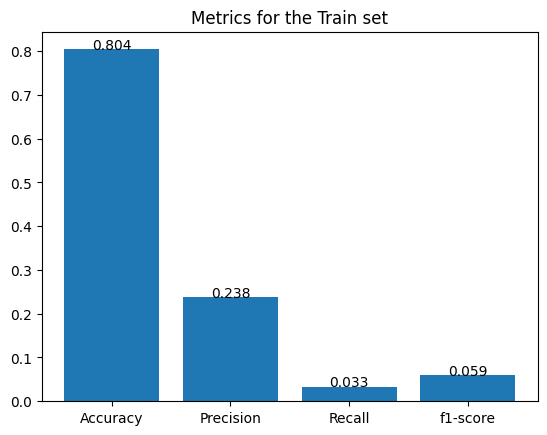

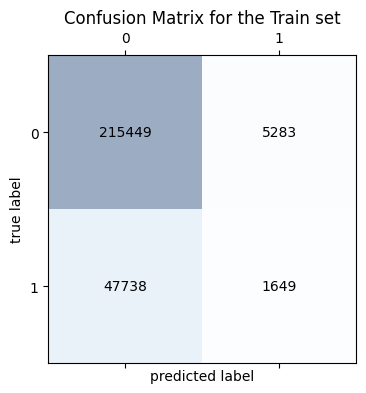

In [6]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

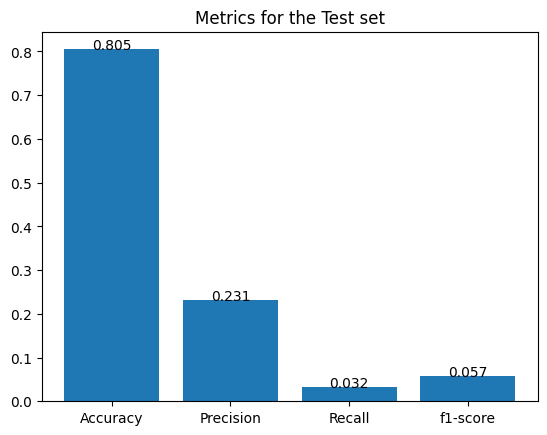

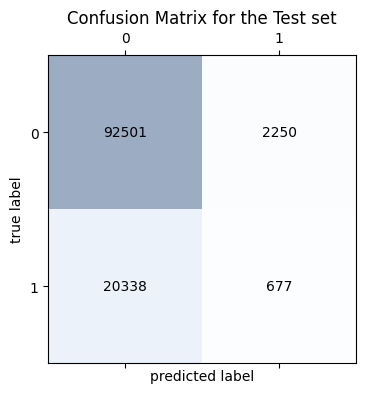

In [7]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

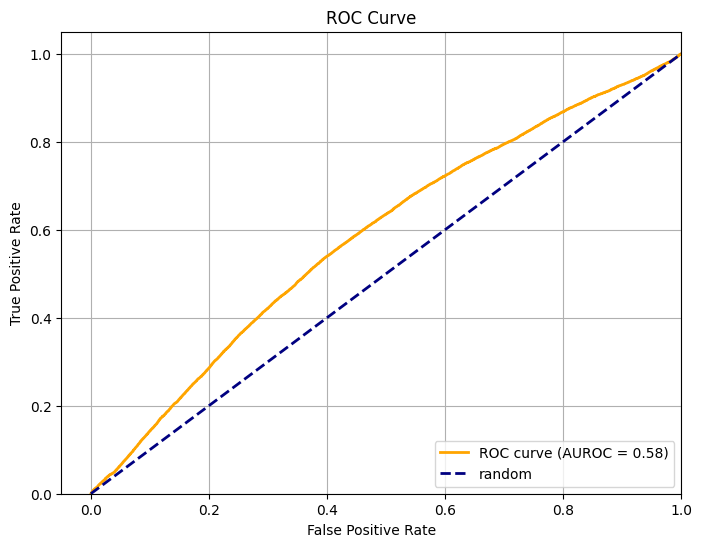

In [8]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [9]:
len(X_test["station"].value_counts())

37

Recall requirement: (False, 0.03221508446347847)


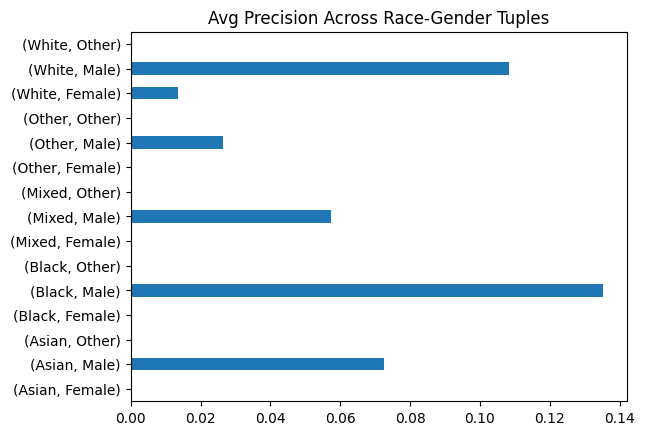

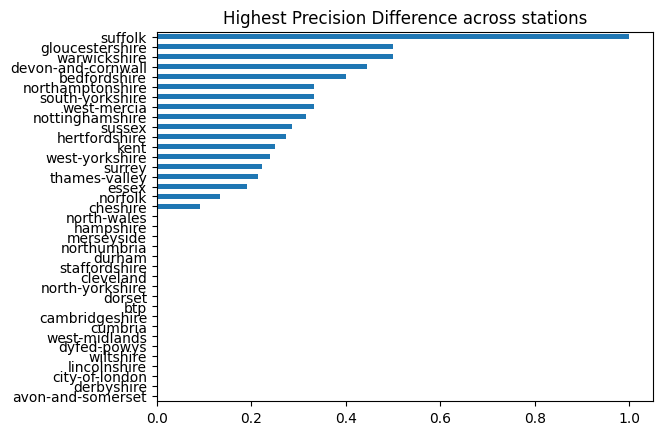

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.10830109996968061, ('White', 'Female'): 0.013513513513513514, ('White', 'Other'): 0.0, ('Black', 'Male'): 0.13524541480151298, ('Black', 'Female'): 0.0, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.07248773917057308, ('Asian', 'Female'): 0.0, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.05735930735930735, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.026442918891431477, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 18
Num good departments: 19
avg diff: 0.1638102702702703


In [10]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

## Hypothesis 2 - Also drop Lat and Lon



# Pipeline Definition

In [11]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    time_cols = ['Date']

    categorical_cols = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer())
        ])

    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            # ('imputer', SimpleImputer(strategy='constant', fill_value=False)),
            ('bool_transformer', BoolTransformer())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Predict

In [12]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.23432116 0.27234927 0.23169955 0.22116461 0.25163704]


In [13]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

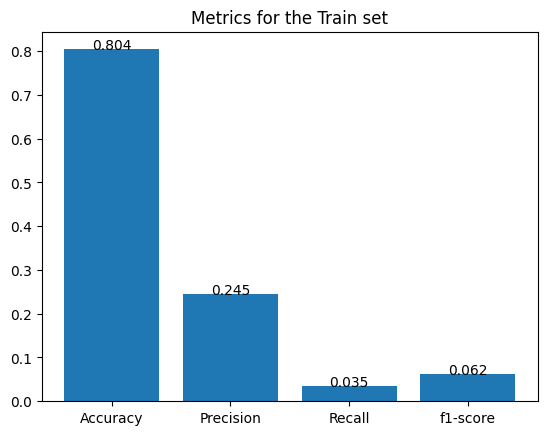

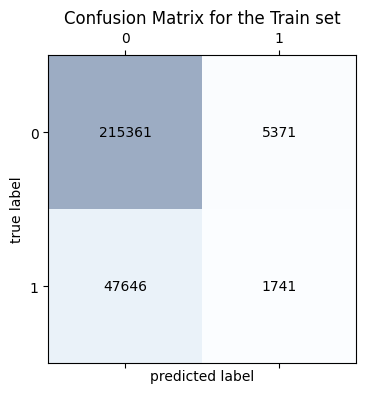

In [14]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

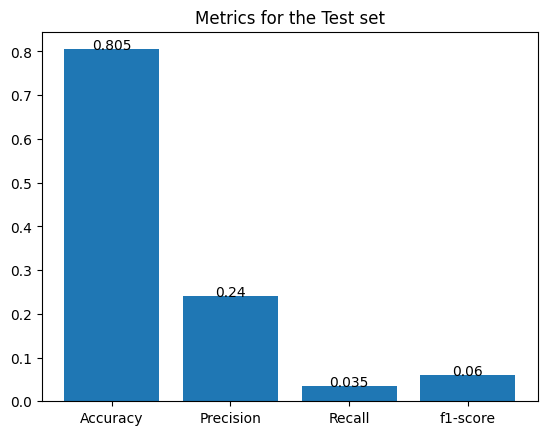

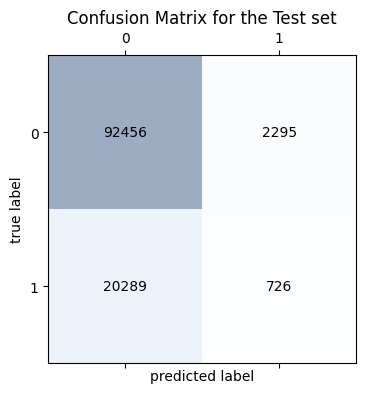

In [15]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

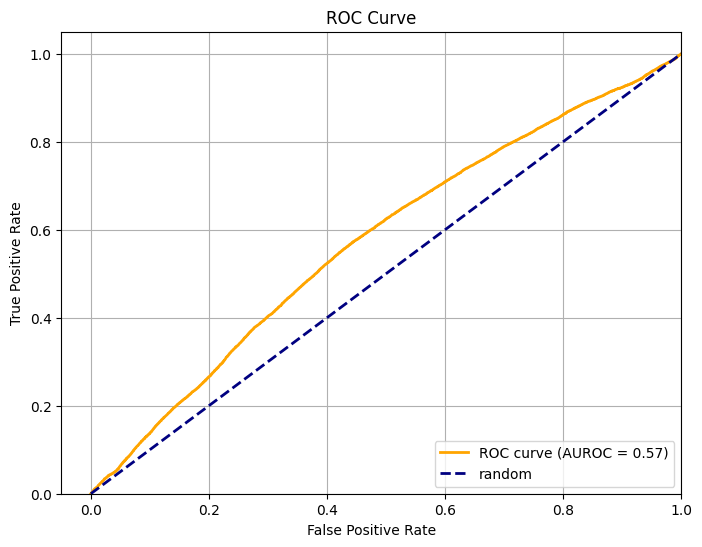

In [16]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [17]:
len(X_test["station"].value_counts())

37

Recall requirement: (False, 0.03454675231977159)


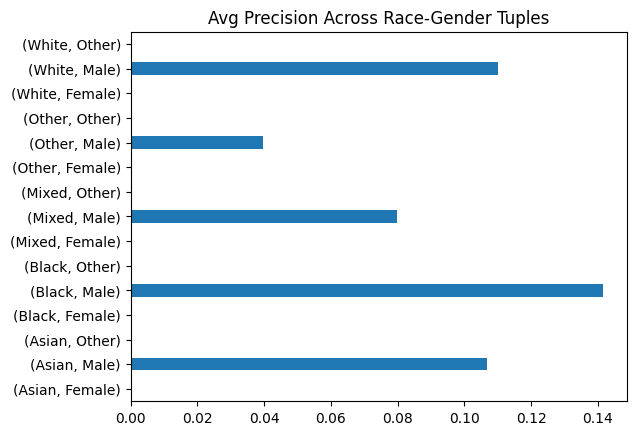

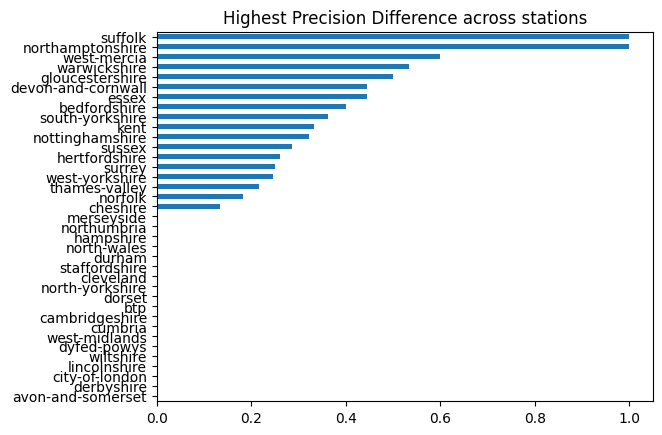

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.1101123661459775, ('White', 'Female'): 0.0, ('White', 'Other'): 0.0, ('Black', 'Male'): 0.14154569457466737, ('Black', 'Female'): 0.0, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.10667997829652058, ('Asian', 'Female'): 0.0, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.07976190476190477, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.03954013822434875, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 18
Num good departments: 19
avg diff: 0.20316108108108108


In [18]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")